### 当时显存(4g)不够支撑，demo只展示了预训练模型的使用

- awesome-semantic-segmentation-pytorch https://github.com/Tramac/awesome-semantic-segmentation-pytorch/blob/master/core/models/deeplabv3_plus.py
- 在PyTorch中使用DeepLabv3进行语义分割的迁移学习 https://blog.csdn.net/deephub/article/details/111352267
- v1、v2、v3、v3+ 概要 https://zhuanlan.zhihu.com/p/68531147
- DeepLabv3 https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/

In [1]:
import os
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import models
from torchvision.datasets import VOCSegmentation

import ttt as T

In [2]:
class SegmentationPresetTrain:
    def __init__(self, *, base_size, crop_size, hflip_prob=0.5, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
        min_size = int(0.5 * base_size)
        max_size = int(2.0 * base_size)

        trans = [T.RandomResize(min_size, max_size)]
        if hflip_prob > 0:
            trans.append(T.RandomHorizontalFlip(hflip_prob))
        trans.extend(
            [
                T.RandomCrop(crop_size),
                T.PILToTensor(),
                T.ConvertImageDtype(torch.float),
                T.Normalize(mean=mean, std=std),
            ]
        )
        self.transforms = T.Compose(trans)

    def __call__(self, img, target):
        return self.transforms(img, target)


class VOCDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        super(VOCDataset, self).__init__()
        self.root = root
        self.transform = transform
        self.classes = (
            'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
            'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
        )
        self.class_to_idx = {_class: i for i, _class in enumerate(self.classes)}

        suffix = 'trainval' if train else 'val'

        files = os.path.join(root, 'ImageSets', 'Segmentation', f'{suffix}.txt')
        # files = os.path.join(root, f'a.txt')  # fixme
        self.files = [id_.strip() for id_ in open(files)]

    def __getitem__(self, sid):
        name = self.files[sid]
        anno = ET.parse(os.path.join(self.root, 'Annotations', f'{name}.xml'))

        # bbox = []
        # for obj in anno.findall('object'):
        #     cname = obj.find('name').text.lower().strip()
        #     sid = self.classes.index(cname)
        #     boxEl = obj.find('bndbox')
        #     box = []
        #     for tag in ('ymin', 'xmin', 'ymax', 'xmax'):
        #         box.append(int(boxEl.find(tag).text) - 1)
        #
        #     box.append(sid)
        #     bbox.append(box)
        #
        # bbox = np.stack(bbox).astype(np.float32)

        img_file = os.path.join(self.root, 'JPEGImages', f'{name}.jpg')
        mask_file = os.path.join(self.root, 'SegmentationClass', f'{name}.png')
        img = Image.open(img_file)
        mask = Image.open(mask_file)
        img = img.convert("RGB")

        if self.transform:
            # img, mask = self.transform(img, mask)
            img = self.transform(img)
            # mask = self.transform(mask)
            mask = transforms.Compose([transforms.ToTensor()])(mask)

        return img, mask  #, bbox, name

    def __len__(self):
        return len(self.files)


# transform = transforms.Compose([
#     # transforms.RandomCrop(256),
#     # transforms.RandomHorizontalFlip(),
#     transforms.Resize(128),  # 大小不一样不行
#     transforms.CenterCrop(128),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
#     # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
# ])
# dataset1 = VOCDataset(root="../../datasets" + "/VOC2012", train=True, transform=transform)
# dataset1 = VOCSegmentation(root="../../datasets", image_set="train", year='2012', transform=transform, target_transform=transform)
transform = SegmentationPresetTrain(base_size=128, crop_size=128)
dataset1 = VOCSegmentation(root="../../datasets", image_set="train", year='2012', transforms=transform)
train_loader: DataLoader = torch.utils.data.DataLoader(dataset1, batch_size=16, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


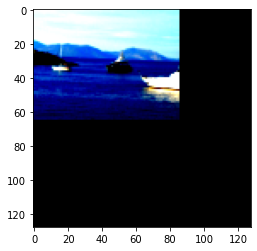

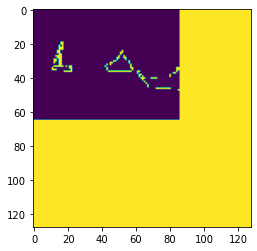

In [3]:
def imshow(img, bbox, name):
    # (c, h, w) => (h, w, c) (3, 375, 500) => (375, 500, 3)
    img = img.permute(1, 2, 0)
    plt.imshow(img)  # img.shape (w, h, c)
    plt.show()


img, mask = train_loader.dataset[6]  # , bbox, name
imshow(img, [], 'name')
plt.imshow(mask)

In [4]:
class DeeplabV3plus(nn.Module):
    def __init__(self) -> None:
        super(DeeplabV3plus).__init__()

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        return x

    def decode(self, x):
        return x


model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)
# model.classifier = DeepLabHead(2048, 21)
model.cuda()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [5]:
optimizer = torch.optim.Adadelta(model.parameters(), lr=1)


# criterion = nn.CrossEntropyLoss()
# criterion.cuda()
def criterion(inputs, target):
    losses = {}
    for name, x in inputs.items():
        losses[name] = nn.functional.cross_entropy(x, target, ignore_index=255)

    if len(losses) == 1:
        return losses["out"]

    return losses["out"] + 0.5 * losses["aux"]


scheduler = StepLR(optimizer=optimizer, step_size=1, gamma=.7)

In [6]:
def train(model: nn.Module, train_loader, optimizer: torch.optim.Optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if len(data) == 1:
            # BN 1 的时候有坑
            continue

        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()

        # output:dict = model(data) # (16, 21, 128, 128)
        # output = output['out'][0]
        # target = target.argmax(0) # (16, 128, 128)
        # print('size', output.shape, target.shape)
        # loss = criterion(output, target)

        outputs = model(data)  # (16, 21, 128, 128)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            # Train Epoch: 2 [16640/60000 (28%)]	Loss: 0.142410
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                loss.item()))

In [7]:
for epoch in range(5):
    train(model, train_loader, optimizer, epoch + 1)
    scheduler.step()

Train Epoch: 1 [0/1464 (0%)]	Loss: 1.374644
Train Epoch: 1 [160/1464 (11%)]	Loss: 3.713283
Train Epoch: 1 [320/1464 (22%)]	Loss: 1.999901
Train Epoch: 1 [480/1464 (33%)]	Loss: 2.319064
Train Epoch: 1 [640/1464 (43%)]	Loss: 2.074040
Train Epoch: 1 [800/1464 (54%)]	Loss: 2.005910
Train Epoch: 1 [960/1464 (65%)]	Loss: 2.807415
Train Epoch: 1 [1120/1464 (76%)]	Loss: 2.484354
Train Epoch: 1 [1280/1464 (87%)]	Loss: 2.856246
Train Epoch: 1 [1440/1464 (98%)]	Loss: 1.866575
Train Epoch: 2 [0/1464 (0%)]	Loss: 2.408051
Train Epoch: 2 [160/1464 (11%)]	Loss: 2.682767
Train Epoch: 2 [320/1464 (22%)]	Loss: 1.649385
Train Epoch: 2 [480/1464 (33%)]	Loss: 2.211610
Train Epoch: 2 [640/1464 (43%)]	Loss: 1.782402
Train Epoch: 2 [800/1464 (54%)]	Loss: 1.628824
Train Epoch: 2 [960/1464 (65%)]	Loss: 2.113767
Train Epoch: 2 [1120/1464 (76%)]	Loss: 2.455691
Train Epoch: 2 [1280/1464 (87%)]	Loss: 1.769802
Train Epoch: 2 [1440/1464 (98%)]	Loss: 2.252993
Train Epoch: 3 [0/1464 (0%)]	Loss: 2.031155
Train Epoch: 3 [

In [8]:
torch.save(model.state_dict(), 'temp.pth')

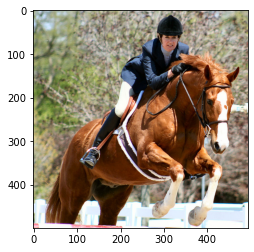

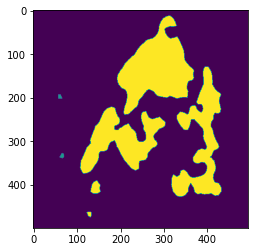

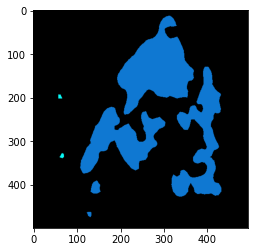

In [9]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# model.cuda()
model.eval()
# input_tensor, _ = train_loader.dataset[5]  # , bbox, name
# img_file = os.path.join("../demo3-7_use_cnn", 'dog.jpg')
name = '2008_002762'
img_file = os.path.join("../../datasets" + "/VOCdevkit/VOC2012", 'JPEGImages', f'{name}.jpg')
input_image = Image.open(img_file)
plt.imshow(input_image)
plt.show()
input_image = input_image.convert("RGB")

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

with torch.no_grad():
    output = model(input_batch.cuda())
output = output['out'][0]
output_predictions = output.argmax(0)
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
colors = (colors % 255).numpy().astype("uint8")

r = Image.fromarray(output_predictions.byte().cpu().numpy())  #.resize((128, 128))
r.putpalette(colors)

plt.imshow(output_predictions.cpu())
plt.show()
plt.imshow(r)
plt.show()